# Diamond Price Prediction

## Data reference: 

Diamond Price Prediction (https://www.kaggle.com/datasets/ritikmaheshwari/diamond-price-prediction/data?select=Diamond_Price_Prediction.ipynb)

## About the dataset

* Data description: The dataset describes the physical and qualitative characteristics of diamonds, including features such as carat weight, cut, color, clarity, depth, table,  and price, which has 53,940 observations and 10 variables.

* The ML problem: How to predict a diamond’s price based on its physical and qualitative characteristics?

## Variable Description

* price: The price of the Diamond
* carat: The carat value of the Diamond
* cut: The cut type of the Diamond, it determines the shine
* color: The color value of the Diamond
* clarity: The carat type of the Diamond
* depth: The depth value of the Diamond
* table: Flat facet on its surface — the large, flat surface facet that you can see when you look at the diamond from above.
* x: Width of the diamond
* y: Length of the diamond
* z: Height of the diamond

## Data preprocessing

### Import:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# base modules
from pathlib import Path
import logging
from collections import OrderedDict
from scipy import stats

# for manipulating data
import numpy as np
import pandas as pd
import math
import dill
import scipy
import seaborn as sns

# for Machine Learning
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.inspection import permutation_importance
from scipy.cluster import hierarchy

# for visualization
from matplotlib import pyplot as plt

In [3]:
from transforms import add_date_columns, change_columns_from_str_to_categorical, process_df,split_vals

In [4]:
path_to_repo = Path('..').resolve()
path_to_data = path_to_repo / 'data'

In [5]:
df_raw = pd.read_csv(path_to_data / 'diamonds_data.csv')

In [6]:
df_raw = df_raw.convert_dtypes()

### Look at the data

In [7]:
df_raw.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.2,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [8]:
df_raw.shape

(53940, 10)

In [9]:
df_new = df_raw[(df_raw[['x', 'y', 'z']] != 0).all(axis=1)]

In [10]:
df_new['volume'] = df_new['x'] * df_new['y'] * df_new['z']
df_new['density'] = df_new['carat'] / df_new['volume']
df_new['xy_ratio'] = df_new['x'] / df_new['y']

C:\Users\13983\AppData\Local\Temp\ipykernel_37204\1780417810.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['volume'] = df_new['x'] * df_new['y'] * df_new['z']
C:\Users\13983\AppData\Local\Temp\ipykernel_37204\1780417810.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['density'] = df_new['carat'] / df_new['volume']
C:\Users\13983\AppData\Local\Temp\ipykernel_37204\1780417810.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [11]:
df_new

,carat,cut,color,clarity,depth,table,price,x,y,z,volume,density,xy_ratio
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,38.20203,0.006021,0.992462
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,34.505856,0.006086,1.013021
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,38.076885,0.00604,0.995086
3,0.29,Premium,I,VS2,62.4,58.0,334,4.2,4.23,2.63,46.72458,0.006207,0.992908
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,51.91725,0.005971,0.997701
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.5,115.92,0.006211,0.998264
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61,118.110175,0.006096,0.989565
53937,0.7,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56,114.449728,0.006116,0.996479
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74,140.76612,0.006109,1.004902


In [12]:
df_new.isnull().sum()

carat       0
cut         0
color       0
clarity     0
depth       0
table       0
price       0
x           0
y           0
z           0
volume      0
density     0
xy_ratio    0
dtype: int64

In [13]:
df_new.duplicated().sum()

145

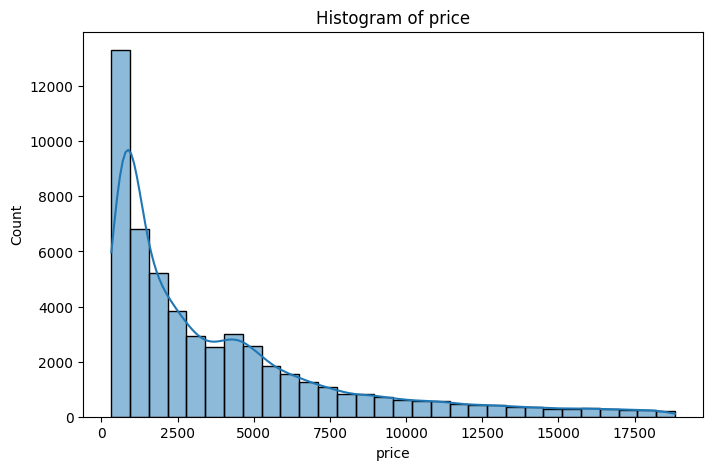

In [14]:
plt.figure(figsize=(8,5))
sns.histplot(df_new["price"], bins=30, kde=True) 
plt.title("Histogram of price")
plt.xlabel("price")
plt.ylabel("Count")
plt.show()

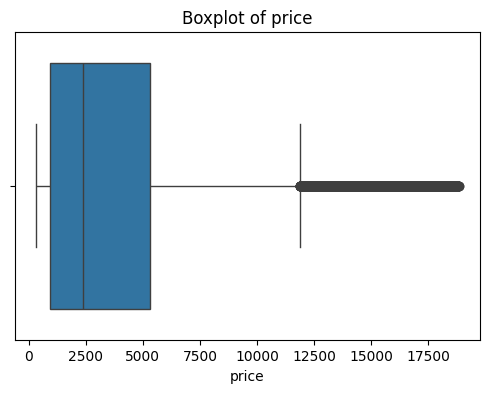

In [15]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df_new["price"])
plt.title("Boxplot of price")
plt.xlabel("price")
plt.show()

In [16]:
df, y, nas = process_df(df_new, y_field='price')

In [17]:
type(df)

pandas.core.frame.DataFrame

In [18]:
df.to_csv(path_to_data / 'processed.csv', index = False)

Now my new dataset:

In [19]:
df = pd.read_csv(path_to_data / 'processed.csv')

In [20]:
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,volume,density,xy_ratio
0,0.23,3,2,4,61.5,55.0,3.95,3.98,2.43,38.202030,0.006021,0.992462
1,0.21,4,2,3,59.8,61.0,3.89,3.84,2.31,34.505856,0.006086,1.013021
2,0.23,2,2,5,56.9,65.0,4.05,4.07,2.31,38.076885,0.006040,0.995086
3,0.29,4,6,6,62.4,58.0,4.20,4.23,2.63,46.724580,0.006207,0.992908
4,0.31,2,7,4,63.3,58.0,4.34,4.35,2.75,51.917250,0.005971,0.997701


In [21]:
y = np.log(y)

In [22]:
y

<FloatingArray>
[ 5.786897381366708,  5.786897381366708, 5.7899601708972535,
  5.811140992976701,  5.814130531825066,  5.817111159963204,
  5.817111159963204,  5.820082930352362,  5.820082930352362,
  5.823045895483019,
 ...
 7.9215356321335495, 7.9215356321335495,  7.921898411023797,
  7.921898411023797,  7.921898411023797,  7.921898411023797,
  7.921898411023797,  7.921898411023797,  7.921898411023797,
  7.921898411023797]
Length: 53920, dtype: Float64

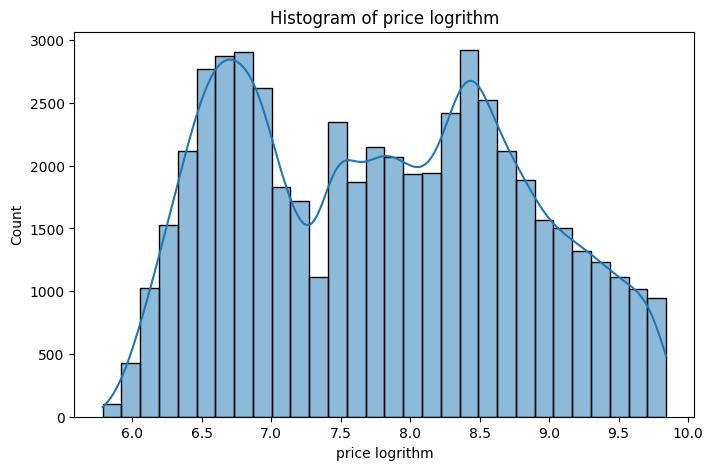

In [23]:
plt.figure(figsize=(8,5))
sns.histplot(y, bins=30, kde=True) 
plt.title("Histogram of price logrithm")
plt.xlabel("price logrithm")
plt.ylabel("Count")
plt.show()

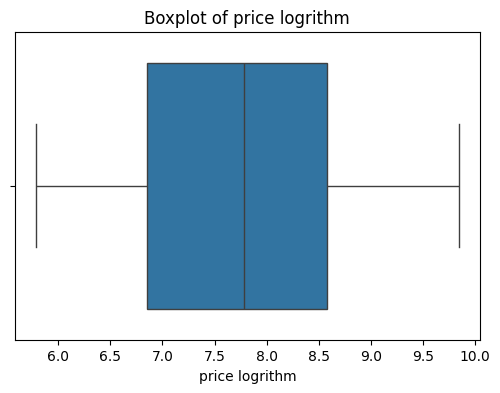

In [24]:
plt.figure(figsize=(6,4))
sns.boxplot(x= y)
plt.title("Boxplot of price logrithm")
plt.xlabel("price logrithm")
plt.show()

In [25]:
y.dtype

Float64Dtype()

In [26]:
df['price'] = y

z_scores = np.abs(stats.zscore(df['price'], nan_policy='omit'))

df = df[z_scores < 2]


In [27]:
y = df['price']
df = df.drop(columns=['price'])

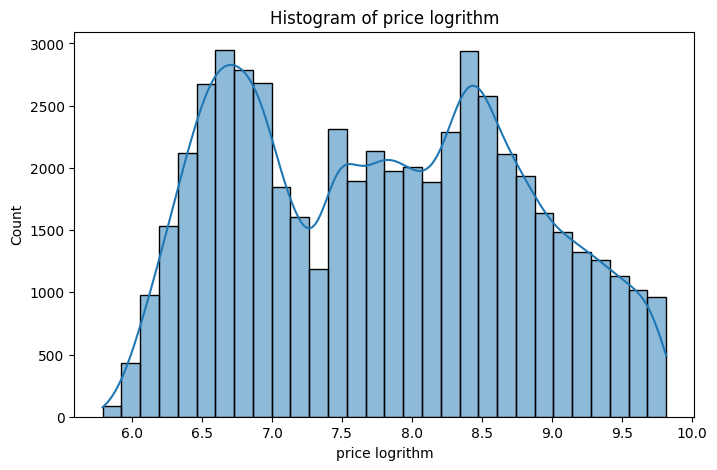

In [28]:
plt.figure(figsize=(8,5))
sns.histplot(y, bins=30, kde=True) 
plt.title("Histogram of price logrithm")
plt.xlabel("price logrithm")
plt.ylabel("Count")
plt.show()

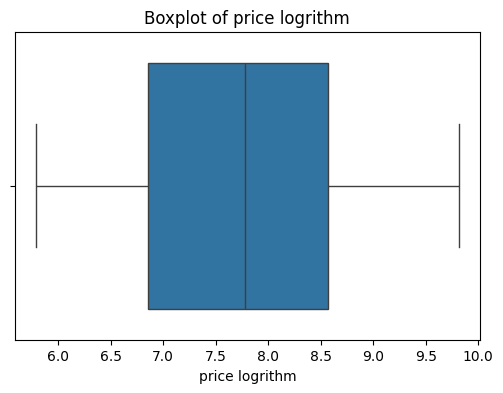

In [29]:
plt.figure(figsize=(6,4))
sns.boxplot(x= y)
plt.title("Boxplot of price logrithm")
plt.xlabel("price logrithm")
plt.show()

## Random Forest Regression

Divide into training dataset and validation dataset

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size=10000, random_state=42)

Some definition

In [35]:
def rmse(y_true, y_pred): 
    return math.sqrt(((y_true - y_pred)**2).mean())

In [36]:
def print_score(m, X_train, y_train, X_valid, y_valid):
    print('RMSE on train set: {:.4f}'.format(rmse(m.predict(X_train), y_train)))
    print('RMSE on valid set: {:.4f}'.format(rmse(m.predict(X_valid), y_valid)))
    print('R^2 on train set: {:.4f}'.format(m.score(X_train, y_train)))
    print('R^2 on valid set: {:.4f}'.format(m.score(X_valid, y_valid)))
    if hasattr(m, 'oob_score_'): print('R^2 on oob set: {:.4f}'.format(m.oob_score_))
    return

Decision Tree Regressor

In [37]:
model_dt = DecisionTreeRegressor(
    criterion = 'squared_error',
    splitter = 'best', 
    max_depth = 5,
    min_samples_split = 3, 
    min_samples_leaf = 3,
    min_weight_fraction_leaf = 0.0, 
    max_features = None, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0,
    random_state = 42, 
)

In [40]:
%time model_dt.fit(X_train, y_train)
print_score(model_dt, X_train, y_train, X_valid, y_valid)

CPU times: total: 78.1 ms
Wall time: 102 ms
RMSE on train set: 0.2103
RMSE on valid set: 0.2114
R^2 on train set: 0.9568
R^2 on valid set: 0.9555


Random Forest Regressor

In [ ]:
model_rf = RandomForestRegressor(
    n_estimators = 10,

    criterion = 'squared_error',
    max_depth = 5,
    min_samples_split = 3, 
    min_samples_leaf = 3,
    min_weight_fraction_leaf = 0.0, 
    max_features = None, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0,
    random_state = 42,
    
    bootstrap = True, 
    oob_score = True, 
    max_samples = 0.3,

    warm_start = False, 
    n_jobs = -1,
    verbose = 0, 
)

In [ ]:
model_rf.fit(X_train, y_train)
print_score(model_rf, X_train, y_train, X_valid, y_valid)

RMSE on train set: 0.1926
RMSE on valid set: 0.1946
R^2 on train set: 0.9636
R^2 on valid set: 0.9629
R^2 on oob set: 0.9629


In [ ]:
rf = RandomForestRegressor (random_state=42)
param_grid = {
    'n_estimators': [30, 50, 80],
    'max_depth': [None, 5, 20],
    'min_samples_split': [5, 10, 30],
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,              
    scoring='r2',
    verbose=2,
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END max_depth=None, min_samples_split=5, n_estimators=30; total time=   2.7s


KeyboardInterrupt: 

In [ ]:
grid_search.best_params_

In [ ]:
%pip install optuna optuna-dashboard
import optuna

Note: you may need to restart the kernel to use updated packages.


In [ ]:
def objective(trial, X_train, y_train, X_valid, y_valid):
    """
    This function estimates a trial quality.
    It contains the 4 steps : hp sampling, model definition, training and evaluation.
    
    Parameters:
    ----------
    trial (optuna.trial.Trial): the trial at stake
    X_training: pd.DataFrame. Table containing features used for training.
    X_validation: pd.DataFrame. Table containing features used for validation.
    y_training: array-like. List of true target variable values for training.
    y_validation: array-like. List of true target variable values for validation.

    Returns:
    -------
    float: performance metric value (R^2)
    """
    
    max_depth_guess = trial.suggest_int("max_depth", 5, 100, log=False)
    min_sample_guess = trial.suggest_int("min_samples_split", 5, 20, log=False)
    estimator_guess = trial.suggest_int("n_estimators", 10, 100, log=False)
    
    model_rf = RandomForestRegressor(
        n_estimators = estimator_guess,

        criterion = 'squared_error',
        max_depth = max_depth_guess,
        min_samples_split = min_sample_guess, 
        min_samples_leaf = 5,
        min_weight_fraction_leaf = 0.0, 
        max_features = None, 
        max_leaf_nodes = None, 
        min_impurity_decrease = 0.0, 
        ccp_alpha = 0.0,
        random_state = 42,
    
        bootstrap = True, 
        oob_score = True, 
        max_samples = 0.3,

        warm_start = False, 
        n_jobs = -1,
        verbose = 0,           
    )
    
    model_rf.fit(X_train, y_train)
    
    y_pred_validation = model_rf.predict(X_valid)
    r2_validation = metrics.r2_score(y_valid, y_pred_validation)
    return r2_validation

In [ ]:
study = optuna.create_study(study_name="ram_opt", 
                            load_if_exists=True, 
                            storage = "sqlite:///ram.db",
                            direction="maximize")

study.optimize(lambda trial: objective(trial, X_train, y_train, X_valid, y_valid), n_trials=100, show_progress_bar=True)

[I 2025-11-28 17:06:34,418] Using an existing study with name 'ram_opt' instead of creating a new one.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-28 17:06:36,659] Trial 250 finished with value: 0.9171871224313571 and parameters: {'max_depth': 98, 'min_samples_split': 5, 'n_estimators': 94}. Best is trial 116 with value: 0.9320273330153968.
[I 2025-11-28 17:06:38,541] Trial 251 finished with value: 0.9172382916740305 and parameters: {'max_depth': 94, 'min_samples_split': 6, 'n_estimators': 97}. Best is trial 116 with value: 0.9320273330153968.
[I 2025-11-28 17:06:40,306] Trial 252 finished with value: 0.9157111958880366 and parameters: {'max_depth': 96, 'min_samples_split': 20, 'n_estimators': 95}. Best is trial 116 with value: 0.9320273330153968.
[I 2025-11-28 17:06:42,268] Trial 253 finished with value: 0.91740219199984 and parameters: {'max_depth': 88, 'min_samples_split': 5, 'n_estimators': 98}. Best is trial 116 with value: 0.9320273330153968.
[I 2025-11-28 17:06:43,604] Trial 254 finished with value: 0.9175660806403495 and parameters: {'max_depth': 92, 'min_samples_split': 6, 'n_estimators': 59}. Best is trial 11

In [ ]:
study.best_params

{'max_depth': 92, 'min_samples_split': 5, 'n_estimators': 96}

In [ ]:
model_rf = RandomForestRegressor(
    n_estimators = 96,

    criterion = 'squared_error',
    max_depth = 92,
    min_samples_split = 5, 
    min_samples_leaf = 5,
    min_weight_fraction_leaf = 0.0, 
    max_features = 92, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0,
    random_state = 42,
    
    bootstrap = True, 
    oob_score = True, 
    max_samples = 0.3,

    warm_start = False, 
    n_jobs = -1,
    verbose = 0,
) 

In [ ]:
model_rf.fit(X_train, y_train)
print_score(model_rf, X_train, y_train, X_valid, y_valid)

RMSE on train set: 0.0882
RMSE on valid set: 0.0971
R^2 on train set: 0.9924
R^2 on valid set: 0.9907
R^2 on oob set: 0.9903


In [ ]:
scores = cross_val_score(model_rf, X_train, y_train, cv = 8, n_jobs = -1)

print(scores)
print("r2 is {:.3f} with a standard deviation of {:.3f}".format(scores.mean(), scores.std()))

[0.98926333 0.99026283 0.99025155 0.98992141 0.98921494 0.98863881
 0.99014245 0.99103507]
r2 is 0.990 with a standard deviation of 0.001


single point check

In [ ]:
point = X_valid.iloc[0,:]
print(point)

carat       0.30
cut         3.00
color       4.00
clarity     5.00
depth      61.40
table      55.00
x           4.32
y           4.38
z           2.67
Name: 45313, dtype: float64


In [ ]:
price = y_valid[0]
print(price, np.exp(price))

KeyError: 0

In [ ]:
np.exp(model_rf.predict([point])[0])

c:\Users\13983\miniconda3\envs\ecl-course-2025\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


605.1350058620862

## Model type 2 -- Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": model.coef_
})
coef_df

,feature,coef
0,carat,-0.554017
1,cut,0.006489
2,color,-0.066235
3,clarity,0.063834
4,depth,0.023390
5,table,-0.007231
6,x,1.010255
7,y,0.026272
8,z,0.179223


In [ ]:
%time model_dt.fit(X_train, y_train)
print_score(model_dt, X_train, y_train, X_valid, y_valid)

CPU times: total: 46.9 ms
Wall time: 64.5 ms
RMSE on train set: 0.2111
RMSE on valid set: 0.2140
R^2 on train set: 0.9563
R^2 on valid set: 0.9551


## Model Type 3 -- XGBoosting

In [ ]:
def reg_perf(regressor, X_training, X_validation, y_true_training, y_true_validation, plot=True):
    y_pred_training = regressor.predict(X_training)
    y_pred_validation = regressor.predict(X_validation)
    rmse_training = metrics.root_mean_squared_error(y_true_training, y_pred_training)
    rmse_validation = metrics.root_mean_squared_error(y_true_validation, y_pred_validation)
    r2_training = metrics.r2_score(y_true_training, y_pred_training)
    r2_validation = metrics.r2_score(y_true_validation, y_pred_validation)
    print("RMSE on training set : {:.3f}".format(rmse_training))
    print("RMSE on validation set : {:.3f}".format(rmse_validation))
    print("R^2 on training set : {:.3f}".format(r2_training))
    print("R^2 on validation set : {:.3f}".format(r2_validation))

    if plot:
        sns.regplot(x=y_true_validation, y=y_pred_validation,  scatter_kws={'s': 1, 'alpha':0.7})
        plt.xlabel("true target variable")
        plt.ylabel("predicted target variable")
        plt.title("Regressor prediction vs truth on validation set")
        plt.show()

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb = XGBRegressor(
    n_estimators=100,        
    learning_rate=0.1,       
    max_depth=6,             
    min_child_weight=1,      
    gamma=0.0,               
    subsample=1.0,           
    colsample_bytree=1.0,   
    colsample_bylevel=1.0,   
    colsample_bynode=1.0,    
    reg_alpha=0.0,           
    reg_lambda=1.0,          
    tree_method="hist",      
    booster="gbtree",        
    objective="reg:squarederror",
    eval_metric=None,        
    early_stopping_rounds=None,  
    random_state=42,
    verbosity=1              
)

In [ ]:
%time xgb.fit(X_train, y_train)

CPU times: total: 1.84 s
Wall time: 743 ms


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=1.0,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

RMSE on training set : 0.086
RMSE on validation set : 0.089
R^2 on training set : 0.993
R^2 on validation set : 0.992


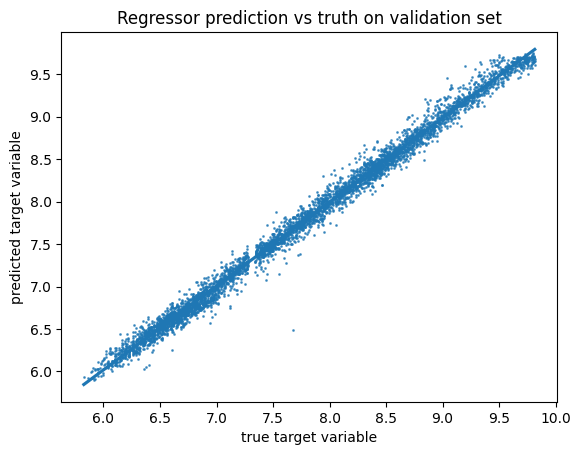

In [ ]:
reg_perf(xgb, X_train, X_valid, y_train, y_valid)

## Catboost

In [ ]:
from catboost import CatBoostRegressor, Pool, cv, CatBoostClassifier

In [ ]:
catboost = CatBoostRegressor(
    n_estimators = 500, 
    random_seed = 42,
    loss_function = 'RMSE',
    custom_metric = 'R2',
    logging_level = 'Silent',
    learning_rate = 0.1,
    depth = 5,
    l2_leaf_reg = 3.0,
    early_stopping_rounds = 50
)

In [ ]:
%time catboost.fit(X_train_cat, np.array(y_train_cat))


CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=1]="Ideal": Cannot convert 'b'Ideal'' to float

In [ ]:
reg_perf(catboost, X_train_cat, X_valid_cat, y_train_cat, y_valid_cat, plot=True)

## Model interpretation

In [ ]:
model_rf.feature_importances_

array([7.66293111e-02, 5.39627844e-04, 1.46019397e-02, 3.00881613e-02,
       8.71024007e-04, 5.83958610e-04, 2.19540815e-02, 8.53201141e-01,
       1.53075532e-03])

In [ ]:
rf_feat_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_rf.feature_importances_
}).sort_values('importance', ascending=False)

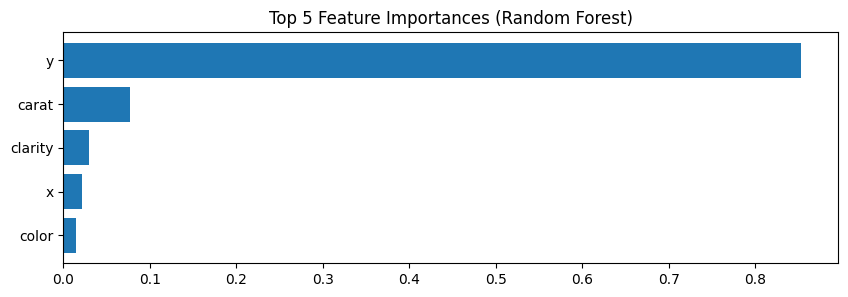

In [ ]:
plt.figure(figsize=(10,3))
plt.barh(rf_feat_importance['feature'][:5], rf_feat_importance['importance'][:5])
plt.gca().invert_yaxis()
plt.title("Top 5 Feature Importances (Random Forest)")
plt.show()

My features count is small, and each of their importance is larger than 0.001, so I regard all of them are important, and choose not to delete less important features

### Permutation Importance

In [ ]:
result = permutation_importance(
    model_rf, 
    X_valid, 
    y_valid, 
    n_repeats = 10,
    random_state = 42, n_jobs = -1,
)
sorted_idx = result.importances_mean.argsort()

In [ ]:
result

{'importances_mean': array([6.33754008e-01, 1.33969595e-03, 1.25757653e-01, 2.76425749e-01,
        8.50050652e-04, 4.96168909e-04, 1.73689606e-01, 8.81708498e-01,
        1.15944936e-03]),
 'importances_std': array([0.02384422, 0.00037508, 0.00556448, 0.01396732, 0.00028363,
        0.00017476, 0.00569798, 0.03304043, 0.00073056]),
 'importances': array([[ 6.35032041e-01,  6.42203038e-01,  6.36544182e-01,
          5.91646852e-01,  6.25310923e-01,  6.09652867e-01,
          6.84829004e-01,  6.45301163e-01,  6.48298340e-01,
          6.18721670e-01],
        [ 1.49534991e-03,  1.10987324e-03,  1.91733497e-03,
          1.63274465e-03,  8.43677313e-04,  8.45371412e-04,
          1.91153551e-03,  1.25231490e-03,  1.34103219e-03,
          1.04772537e-03],
        [ 1.20254768e-01,  1.29437007e-01,  1.25783633e-01,
          1.16638830e-01,  1.37208499e-01,  1.30151780e-01,
          1.26508876e-01,  1.27332015e-01,  1.20931221e-01,
          1.23329905e-01],
        [ 2.78261656e-01,  3.

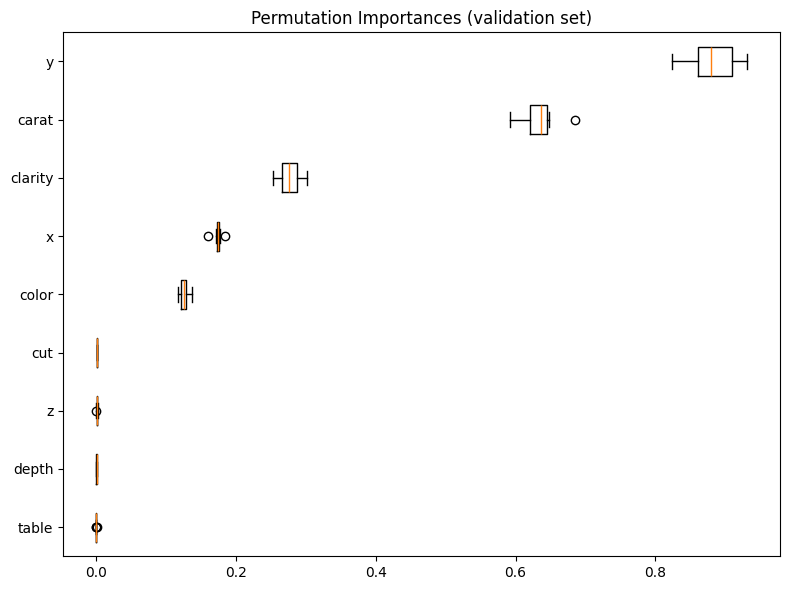

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.boxplot(
    result.importances[sorted_idx].T,
    vert = False, 
    tick_labels = X_valid.columns[sorted_idx],
)
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

### Feature correlations

In [ ]:
cols = df.columns.tolist()

In [ ]:
corr = np.round(scipy.stats.spearmanr(df[cols]).correlation, 4)
corr.size

81

C:\Users\13983\AppData\Local\Temp\ipykernel_12928\2058658202.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + cols)
C:\Users\13983\AppData\Local\Temp\ipykernel_12928\2058658202.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + cols)


[Text(0, -1.0, ''),
 Text(0, 0.0, 'carat'),
 Text(0, 1.0, 'cut'),
 Text(0, 2.0, 'color'),
 Text(0, 3.0, 'clarity'),
 Text(0, 4.0, 'depth'),
 Text(0, 5.0, 'table'),
 Text(0, 6.0, 'x'),
 Text(0, 7.0, 'y'),
 Text(0, 8.0, 'z'),
 Text(0, 9.0, '')]

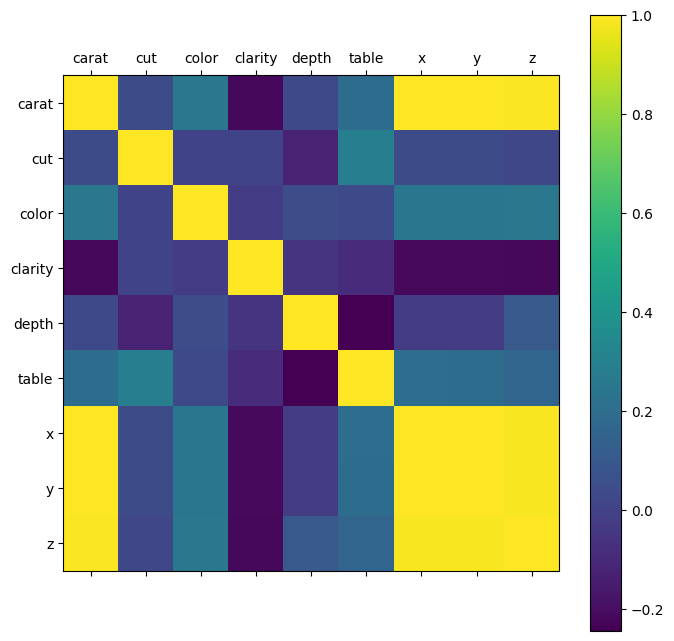

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(corr)
fig.colorbar(cax)
ax.set_xticklabels([''] + cols)
ax.set_yticklabels([''] + cols)

In [ ]:
corr_condensed = hierarchy.distance.squareform(1 - corr)
corr_condensed.size

36

In [ ]:
corr_linkage = hierarchy.linkage(corr_condensed, method = 'average')

In [ ]:
corr_linkage

array([[6.00000000e+00, 7.00000000e+00, 2.10000000e-03, 2.00000000e+00],
       [0.00000000e+00, 9.00000000e+00, 4.15000000e-03, 3.00000000e+00],
       [8.00000000e+00, 1.00000000e+01, 1.07666667e-02, 4.00000000e+00],
       [1.00000000e+00, 5.00000000e+00, 7.11600000e-01, 2.00000000e+00],
       [2.00000000e+00, 1.10000000e+01, 7.52150000e-01, 5.00000000e+00],
       [1.20000000e+01, 1.30000000e+01, 9.06470000e-01, 7.00000000e+00],
       [4.00000000e+00, 1.40000000e+01, 1.03402857e+00, 8.00000000e+00],
       [3.00000000e+00, 1.50000000e+01, 1.12702500e+00, 9.00000000e+00]])

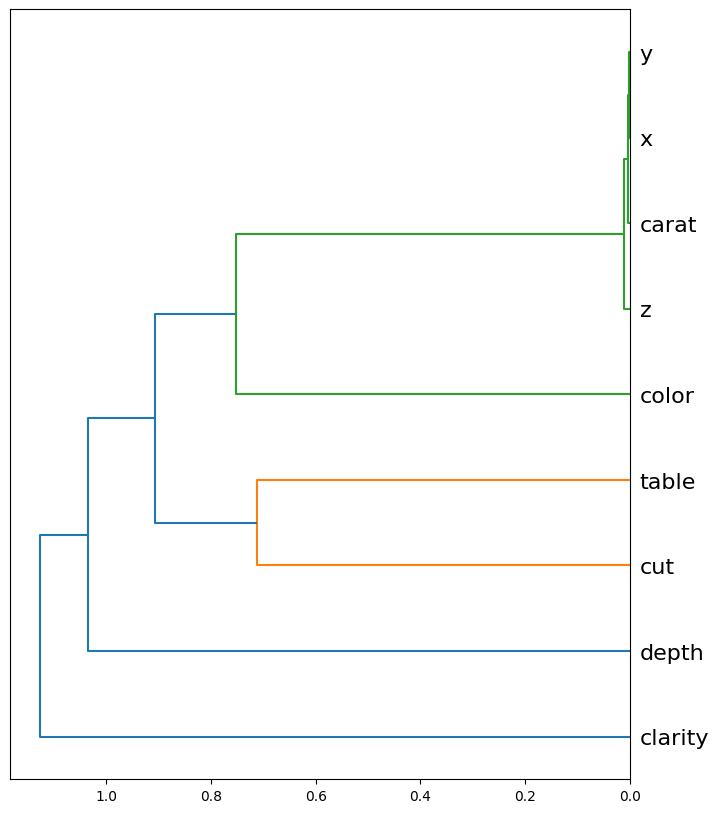

In [ ]:
fig = plt.figure(figsize = (8,10))
dendrogram = hierarchy.dendrogram(
    corr_linkage, 
    labels = cols, 
    orientation = 'left', 
    leaf_font_size = 16,
)
plt.show()